In [1]:
import torch
import numpy as np
# from sklearn.linear_model import Ridge
from himalaya.ridge import Ridge, RidgeCV
from himalaya.backend import set_backend
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cpu")
import matplotlib.pyplot as plt

In [ ]:
## Loading BOLD5000 data

BOLD_brain_signals_train = torch.load("BOLD5000_V2/brain_signals_train.pt", map_location=device)
BOLD_brain_signals_test = torch.load("BOLD5000_V2/brain_signals_test.pt", map_location=device)

BOLD_brain_signals_train = torch.from_numpy(BOLD_brain_signals_train).to(device)
BOLD_brain_signals_test = torch.from_numpy(BOLD_brain_signals_test).to(device)

# Normalizing the BOLD signals

# mean = BOLD_brain_signals_train.mean(0)
# std = BOLD_brain_signals_train.std(0)
# BOLD_brain_signals_train = (BOLD_brain_signals_train - mean) / std
# BOLD_brain_signals_test = (BOLD_brain_signals_test - mean) / std

# BOLD_brain_signals_train = torch.nan_to_num(BOLD_brain_signals_train)
# BOLD_brain_signals_test = torch.nan_to_num(BOLD_brain_signals_test)



BOLD_train_img_embeds = torch.load("BOLD5000_V2/image_embeddings_train.pt", map_location=device)
BOLD_test_img_embeds = torch.load("BOLD5000_V2/image_embeddings_test.pt", map_location=device)

# BOLD_train_img_embeds = BOLD_train_img_embeds[:, 1, 0].float()
# BOLD_test_img_embeds = BOLD_test_img_embeds[:, 1, 0].float()



In [3]:

X_train = BOLD_train_img_embeds[:4803].numpy()

X_test = BOLD_test_img_embeds[:113].numpy()

Y_train= BOLD_brain_signals_train[:4803].numpy()
Y_test = BOLD_brain_signals_test[:113].numpy()



# X_train = BOLD_train_img_embeds[4803:9606].numpy()

# X_test = BOLD_test_img_embeds[113:226].numpy()

# Y_train= BOLD_brain_signals_train[4803:9606].numpy()
# Y_test = BOLD_brain_signals_test[113:226].numpy()



# X_train = BOLD_train_img_embeds[9606:14409].numpy()

# X_test = BOLD_test_img_embeds[226:339].numpy()

# Y_train= BOLD_brain_signals_train[9606:14409].numpy()
# Y_test = BOLD_brain_signals_test[226:339].numpy()


# X_train = BOLD_train_img_embeds[14409:].numpy()

# X_test = BOLD_test_img_embeds[339:].numpy()

# Y_train= BOLD_brain_signals_train[14409:].numpy()
# Y_test = BOLD_brain_signals_test[339:].numpy()

In [4]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((4803, 1280), (113, 1280), (4803, 15724), (113, 15724))

In [5]:
set_backend("torch_cuda")

ridge = Ridge(alpha=50000.0) 
ridge.fit(X_train, Y_train)

Y_pred = ridge.predict(X_test)


r2 = r2_score(Y_test, Y_pred, multioutput='uniform_average')
print(f"R² Score on Test Data: {r2:.4f}")


voxel_correlations = np.array([
    pearsonr(Y_test[:, v], Y_pred[:, v])[0] if np.std(Y_test[:, v]) > 0 else 0 for v in range(Y_test.shape[1])])


mean_voxel_corr = np.median(voxel_correlations)
print(f"Median Voxel-wise Correlation: {mean_voxel_corr:.4f}")

R² Score on Test Data: 0.0779
Median Voxel-wise Correlation: 0.2023


In [7]:
res  = ((Y_test-Y_pred.numpy())**2).mean(0)

(array([ 559.,    0.,    0.,   27.,  675., 4194., 6066., 3330.,  774.,
          99.]),
 array([0.        , 0.14779513, 0.29559025, 0.44338539, 0.5911805 ,
        0.73897564, 0.88677078, 1.03456593, 1.18236101, 1.33015621,
        1.47795129]),
 <BarContainer object of 10 artists>)

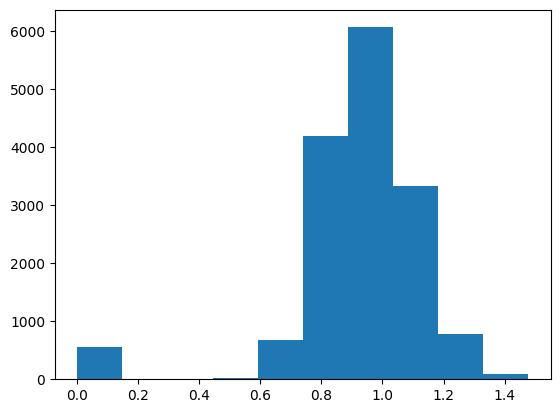

In [8]:
plt.hist(res)

(array([  54.,  180., 1612., 2169., 3438., 3600., 2772., 1341.,  450.,
         108.]),
 array([-0.24768138, -0.15934568, -0.07100998,  0.01732572,  0.10566142,
         0.19399712,  0.28233282,  0.37066852,  0.45900423,  0.54733993,
         0.63567563]),
 <BarContainer object of 10 artists>)

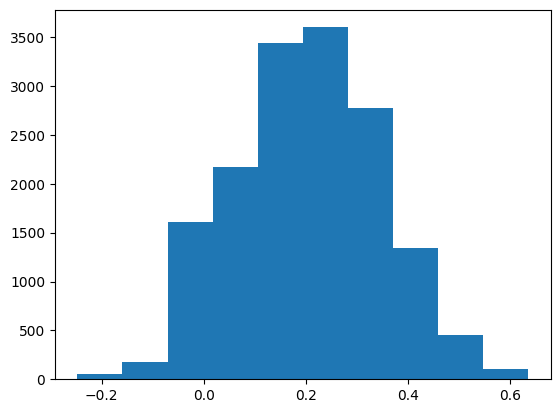

In [9]:
plt.hist(voxel_correlations)

In [ ]:
aug_image_embds = torch.load("/decoding_NSD/data_augmentation/image_embeddings.pt")
aug_image_embds = aug_image_embds[:, 1, 0].float()

aug_image_embds.shape

torch.Size([8859, 1280])

In [11]:
subj2_pred = ridge.predict(aug_image_embds)

In [12]:
subj2_pred.shape

torch.Size([8859, 15724])

In [21]:
from scipy.stats import rv_histogram

# Example histogram data (assuming a histogram was computed)
hist_data = np.histogram(res, bins=5, density=True)

# Create a continuous distribution from the histogram
hist_dist = rv_histogram(hist_data)

# Sample from the distribution
samples = hist_dist.rvs(size=subj2_pred.shape)
print(samples.mean())
print(samples.std())


noise_scale = 1.0


subj1_pred_noise = subj2_pred + samples*noise_scale

0.926861116919889
0.23696021064045986


In [ ]:
torch.save(subj1_pred_noise, "/BOLD5000/data_augmentation/100_percent/subject1.pt")

In [ ]:
# import torch
# import torchvision.transforms as transforms
# from torchvision.datasets import ImageFolder
# from torch.utils.data import DataLoader, Subset
# import random
# import os


# dataset_path = "/imageNet/ilsvrc2012/versions/1"  
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  
#     transforms.ToTensor(),         
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
# ])


# dataset = ImageFolder(root=dataset_path, transform=transform)


# random_indices = random.sample(range(len(dataset)), 8859)


# subset = Subset(dataset, random_indices)


# dataloader = DataLoader(subset, batch_size=64, shuffle=False)  # Adjust batch size as needed


# image_tensors = []
# for images, _ in dataloader:
#     image_tensors.append(images)


# final_tensor = torch.cat(image_tensors, dim=0)  # Shape: (8859, 3, 224, 224)






In [ ]:
subj1_aug = torch.load("/BOLD5000/data_augmentation/100_percent/subject1.pt")
subj5_aug = torch.load("/BOLD5000/data_augmentation/100_percent/subject3.pt")
subj2_aug = torch.load("/BOLD5000/data_augmentation/100_percent/subject2.pt")
subj7_aug = torch.load("/BOLD5000/data_augmentation/100_percent/subject4.pt")


In [211]:
subj8 = BOLD_brain_signals_train[:4803]
subj9 = BOLD_brain_signals_train[4803:9606]
subj10 = BOLD_brain_signals_train[9606:14409]
subj11 = BOLD_brain_signals_train[14409:17255]

subj1_aug.shape, subj5_aug.shape, subj2_aug.shape, subj7_aug.shape, subj8.shape, subj9.shape, subj10.shape, subj11.shape


(torch.Size([8859, 15724]),
 torch.Size([8859, 15724]),
 torch.Size([8859, 15724]),
 torch.Size([8859, 15724]),
 torch.Size([4803, 15724]),
 torch.Size([4803, 15724]),
 torch.Size([4803, 15724]),
 torch.Size([2846, 15724]))

In [212]:
subject8 = torch.cat((subj8, subj1_aug[:4803]), dim=0)
subject9 = torch.cat((subj9, subj2_aug[:4803]), dim=0)
subject10 = torch.cat((subj10, subj5_aug[:4803]), dim=0)
subject11 = torch.cat((subj11, subj7_aug[:2846]), dim=0)

subject8.shape, subject9.shape, subject10.shape, subject11.shape

(torch.Size([9606, 15724]),
 torch.Size([9606, 15724]),
 torch.Size([9606, 15724]),
 torch.Size([5692, 15724]))

In [213]:
train_100percent_noise_10 = torch.cat((subject8, subject9, subject10, subject11), dim=0)

In [214]:
train_100percent_noise_10.shape

torch.Size([34510, 15724])

In [ ]:
torch.save(train_100percent_noise_10, "/BOLD5000/data_augmentation/train_100percent_noise_100.pt")

In [156]:
subj8_image_embds = BOLD_train_img_embeds[:4803]     
subj9_image_embds = BOLD_train_img_embeds[4803:9606] 
subj10_image_embds = BOLD_train_img_embeds[9606:14409]
subj11_image_embds= BOLD_train_img_embeds[14409:17255]

subj8_image_embds.shape, subj9_image_embds.shape, subj10_image_embds.shape, subj11_image_embds.shape

(torch.Size([4803, 2, 1, 1280]),
 torch.Size([4803, 2, 1, 1280]),
 torch.Size([4803, 2, 1, 1280]),
 torch.Size([2846, 2, 1, 1280]))

In [ ]:
aug_image_embds = torch.load("/decoding_NSD/data_augmentation/image_embeddings.pt").to(device)

In [158]:
subj8_image_embds = torch.cat((subj8_image_embds, aug_image_embds[:3602]), dim=0)
subj9_image_embds = torch.cat((subj9_image_embds, aug_image_embds[:3602]), dim=0)
subj10_image_embds = torch.cat((subj10_image_embds, aug_image_embds[:3602]), dim=0)
subj11_image_embds= torch.cat((subj11_image_embds, aug_image_embds[:2134]), dim=0)

train_img_embeds = torch.cat((subj8_image_embds, subj9_image_embds, subj10_image_embds, subj11_image_embds), dim=0)

train_img_embeds.shape

torch.Size([30195, 2, 1, 1280])

In [ ]:
torch.save(train_img_embeds, "/BOLD5000/data_augmentation/train_embds_75percent.pt")

In [ ]:

subject_ids = []


subject_ids.extend([8] * 8405)  
subject_ids.extend([9] * 8405)  
subject_ids.extend([10] * 8405) 
subject_ids.extend([11] * 4980) 


subject_ids_tensor = torch.tensor(subject_ids)
torch.save(subject_ids, "/BOLD5000/data_augmentation/train_ids_75percent.pt")

subject_ids_tensor

tensor([ 8,  8,  8,  ..., 11, 11, 11])

In [39]:
subject_ids_tensor.shape

torch.Size([34510])